In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
from mlens.visualization import corrmat
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from keras import models, layers, optimizers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.calibration import CalibratedClassifierCV

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

#Avoid future warnings: 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\ESFITA-USER\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\ESFITA-USER\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\ESFITA-USER\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and 

In [2]:
df = pd.read_csv('Updated_Train_TW.csv')

In [3]:
#Taking dataset without Customer_Code:
df = df.loc[:,'cus_Gender':]

In [4]:
# Check both the datatypes and if there is missing values
print(f"Data types:\n{11 * '-'}")
print(f"{df.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{df.isnull().sum()}")
df.head()

Data types:
-----------
cus_Gender                   object
cus_MartialTypeId             int64
cus_Dependants                int64
cus_CurrenResTypeId           int64
cus_CurrenStyYear             int64
app_CustBankClosBal           int64
app_CustAssetValue            int64
app_CustProductCatTypeId      int64
app_CustBrandTypeId           int64
app_CustIndustryTypeId        int64
app_CustTenure                int64
app_CustInstalCount           int64
app_CustChasAsset             int64
app_CustChasInitial           int64
app_CustChasFinance           int64
app_CustFinanInterest       float64
app_CustEMI                   int64
app_CustTotInflow             int64
AnotherScore                float64
cus_Age                       int64
DOB_Score                     int64
TOR_Score                     int64
NYS                           int64
Dependant_Score               int64
L2V_Score                     int64
ES_Score                      int64
Salary_Score                  int64
Borr

,cus_Gender,cus_MartialTypeId,cus_Dependants,cus_CurrenResTypeId,cus_CurrenStyYear,app_CustBankClosBal,app_CustAssetValue,app_CustProductCatTypeId,app_CustBrandTypeId,app_CustIndustryTypeId,...,ES_Score,Salary_Score,Borrwing_Score,CIBIL_Score,Overdue_Score,Enquiry_Score,Banking_Score,Avg_Bal_Score,Checkbounce_Score,Label
0,M,2750,0,2755,15,3289,0,1541,1360,879,...,5,5,0,5,0,5,3,4,5,Pay
1,M,2750,2,2755,14,4562,0,1541,1542,879,...,2,5,0,5,5,5,0,4,5,Pay
2,M,2750,2,2755,16,5246,0,1541,1542,879,...,0,5,0,5,0,0,2,5,5,Pay
3,M,2750,4,2755,28,6249,0,1541,1360,879,...,3,5,0,5,3,0,5,5,5,Pay
4,M,2750,3,2755,14,4673,0,1541,1542,879,...,2,5,0,5,3,5,5,5,5,Pay


In [5]:
#Brands are in dataset:
df.app_CustBrandTypeId.value_counts()

1360    231
1542    216
935      37
1544     37
816      28
1547     20
1546     14
1647      8
1549      6
1734      1
1545      1
1476      1
Name: app_CustBrandTypeId, dtype: int64

In [6]:
#Converting the text label into integers:
def cate(val):
    """
    This function is used to converting string classes into integer values.
    """
    if val == 'Pay':
        return 0
    else:
        return 1

#Applying a function cate:
df['Label'] = df['Label'].apply(cate)

Positive examples = 200
Negative examples = 400
Proportion of positive to negative examples = 50.00%


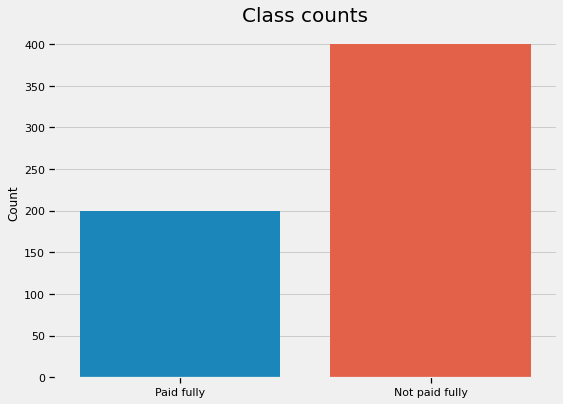

In [92]:
# Get number of positve and negative examples
neg = df[df["Label"] == 1].shape[0]
pos = df[df["Label"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(df.Label)
plt.xticks((0, 1), ["Paid fully", "Not paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});
plt.savefig('data_tw.jpg', bbox_inches='tight')

In [8]:
# Create dummy variables from the feature purpose
df = pd.get_dummies(df, columns=["cus_Gender"])
df.head()

,cus_MartialTypeId,cus_Dependants,cus_CurrenResTypeId,cus_CurrenStyYear,app_CustBankClosBal,app_CustAssetValue,app_CustProductCatTypeId,app_CustBrandTypeId,app_CustIndustryTypeId,app_CustTenure,...,Borrwing_Score,CIBIL_Score,Overdue_Score,Enquiry_Score,Banking_Score,Avg_Bal_Score,Checkbounce_Score,Label,cus_Gender_F,cus_Gender_M
0,2750,0,2755,15,3289,0,1541,1360,879,24,...,0,5,0,5,3,4,5,0,0,1
1,2750,2,2755,14,4562,0,1541,1542,879,18,...,0,5,5,5,0,4,5,0,0,1
2,2750,2,2755,16,5246,0,1541,1542,879,18,...,0,5,0,0,2,5,5,0,0,1
3,2750,4,2755,28,6249,0,1541,1360,879,24,...,0,5,3,0,5,5,5,0,0,1
4,2750,3,2755,14,4673,0,1541,1542,879,24,...,0,5,3,5,5,5,5,0,0,1


In [9]:
df.columns

Index(['cus_MartialTypeId', 'cus_Dependants', 'cus_CurrenResTypeId',
       'cus_CurrenStyYear', 'app_CustBankClosBal', 'app_CustAssetValue',
       'app_CustProductCatTypeId', 'app_CustBrandTypeId',
       'app_CustIndustryTypeId', 'app_CustTenure', 'app_CustInstalCount',
       'app_CustChasAsset', 'app_CustChasInitial', 'app_CustChasFinance',
       'app_CustFinanInterest', 'app_CustEMI', 'app_CustTotInflow',
       'AnotherScore', 'cus_Age', 'DOB_Score', 'TOR_Score', 'NYS',
       'Dependant_Score', 'L2V_Score', 'ES_Score', 'Salary_Score',
       'Borrwing_Score', 'CIBIL_Score', 'Overdue_Score', 'Enquiry_Score',
       'Banking_Score', 'Avg_Bal_Score', 'Checkbounce_Score', 'Label',
       'cus_Gender_F', 'cus_Gender_M'],
      dtype='object')

In [10]:
# Original Data
X = df.loc[:, df.columns != "Label"].values
y = df.loc[:, df.columns == "Label"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((480, 35), (120, 35))


In [11]:
# Build random forest classifier (same config)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

# Build model with no sampling
pip_orig = make_pipeline(Imputer(strategy="median"),rf_clf)
scores = cross_val_score(pip_orig,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Original model's average AUC: {scores.mean():.3f}")

# Build model with undersampling
pip_undersample = imb_make_pipeline(Imputer(strategy="median"),RandomUnderSampler(), rf_clf)
scores = cross_val_score(pip_undersample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Under-sampled model's average AUC: {scores.mean():.3f}")

# Build model with oversampling
pip_oversample = imb_make_pipeline(Imputer(strategy="median"),RandomOverSampler(), rf_clf)
scores = cross_val_score(pip_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Over-sampled model's average AUC: {scores.mean():.3f}")

# Build model with EasyEnsemble
resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
pip_resampled = make_pipeline(Imputer(strategy="median"),resampled_rf)
                             
scores = cross_val_score(pip_resampled,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"EasyEnsemble model's average AUC: {scores.mean():.3f}")

# Build model with SMOTE
pip_smote = imb_make_pipeline(Imputer(strategy="median"),SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"SMOTE model's average AUC: {scores.mean():.3f}")

Original model's average AUC: 0.943
Under-sampled model's average AUC: 0.940
Over-sampled model's average AUC: 0.946
EasyEnsemble model's average AUC: 0.941
SMOTE model's average AUC: 0.937


In [12]:
# Impute the missing data using features means
imp = Imputer(strategy="median")
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)


# Implement RandomOverSampler
sampler = SMOTE()
X_res, y_res = sampler.fit_sample(X_train, y_train)
# Shuffle the data
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]
X_res.shape, y_res.shape

((640, 35), (640,))

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [15]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100,scoring='roc_auc' ,cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
grid.fit(X_res, y_res)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 28.4min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [18]:
print("Area Under Curve on Cross Validation Data:%.2f" % (grid.best_score_*100))
p = grid.best_params_
print(p)

Area Under Curve on Cross Validation Data:97.84
{'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}


In [15]:
# Evaluate a model with optimized parameters:
best_rf = RandomForestClassifier(random_state = 42,n_estimators = 500, min_samples_split =  2, min_samples_leaf =  1, max_features = 'auto', max_depth = 20,bootstrap =  False)
#best_rf = grid.best_estimator_
best_rf.fit(X_res,y_res)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

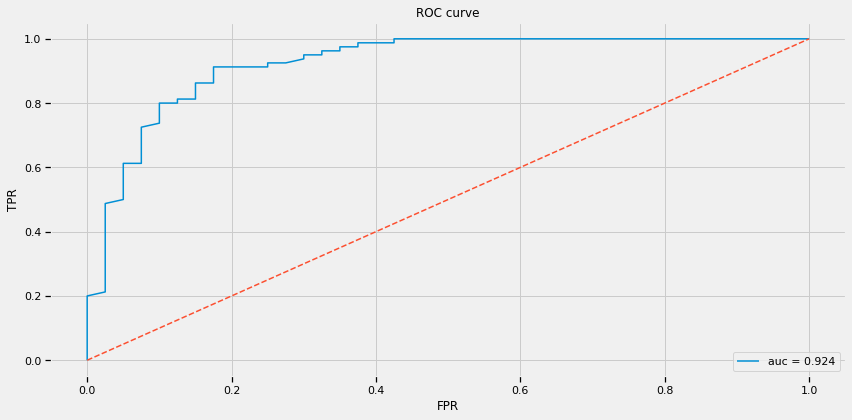

In [93]:
probs = best_rf.predict_proba(X_test)[:, 1:]
auc_score = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f"auc = {auc_score:.3f}")
plt.plot([0,1],[0,1],'--')
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.tight_layout()
plt.savefig('auc_tw.jpg', bbox_inches='tight')

In [17]:
from collections import Counter 
Counter(y_test)

Counter({1: 80, 0: 40})

<Figure size 1152x576 with 0 Axes>

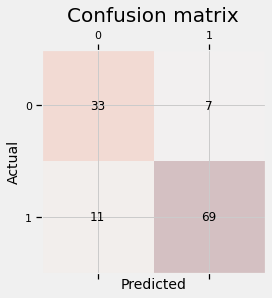

In [91]:
probs = best_rf.predict_proba(X_test)
preds = best_rf.predict(X_test)
conf_mat = confusion_matrix(y_test, preds)
# Define figure size and figure ratios
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})
plt.savefig('cm_tw.jpg', bbox_inches='tight')

In [19]:
#Generating sample status:
sample_weight = np.random.RandomState(42).rand(y.shape[0])
sw_train,sw_test = train_test_split(sample_weight,test_size=0.2)

In [23]:
#Caluculating Probability of 1 for a test data:
clf_isotonic = CalibratedClassifierCV(best_rf,cv=10,method='sigmoid')
clf_isotonic.fit(X_train,y_train,sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:,-1]

In [24]:
# Saving model to disk
pickle.dump(clf_isotonic, open('model_tw_sig.pkl','wb'))

In [22]:
X_test.shape

(120, 35)

In [27]:
#Making results:
for i in prob_pos_isotonic.argsort():
    print("Predicted_Value:{} Actual_Value:{} Probablity of Pay:{}".format(best_rf.predict(X_test[i].reshape(1,35)),y_test[i],(1-(clf_isotonic.predict_proba(X_test[i].reshape(1,35))[:,-1]))))

Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97577983]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97574251]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97008673]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.96473196]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.95969773]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.95278217]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.95158438]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.95044191]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.9473757]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.93848933]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.93209731]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.93206548]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.9138657]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.91030973]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.90488009]
Predicted_Va

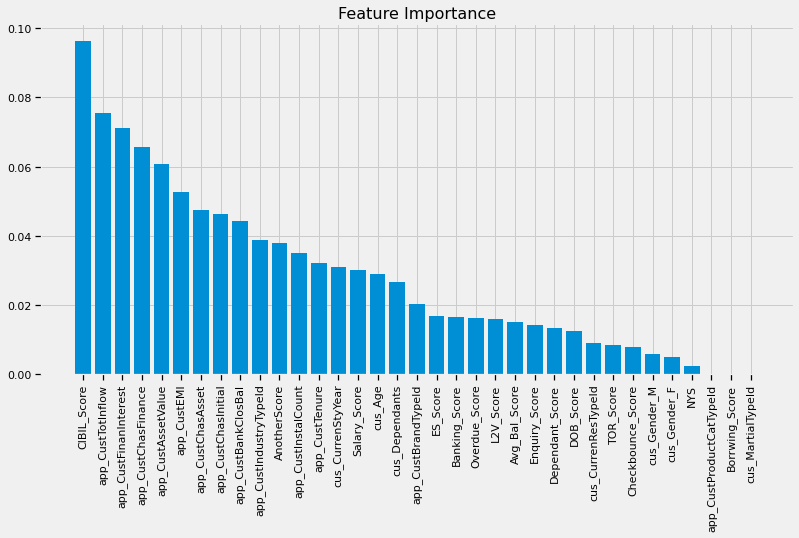

In [90]:
# Plot features importance
importances = best_rf.feature_importances_
indices = np.argsort(best_rf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 36), importances[indices], align="center")
plt.xticks(range(1, 36), df.columns[df.columns != "Label"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16})
plt.savefig('fi_tw.jpg', bbox_inches='tight')

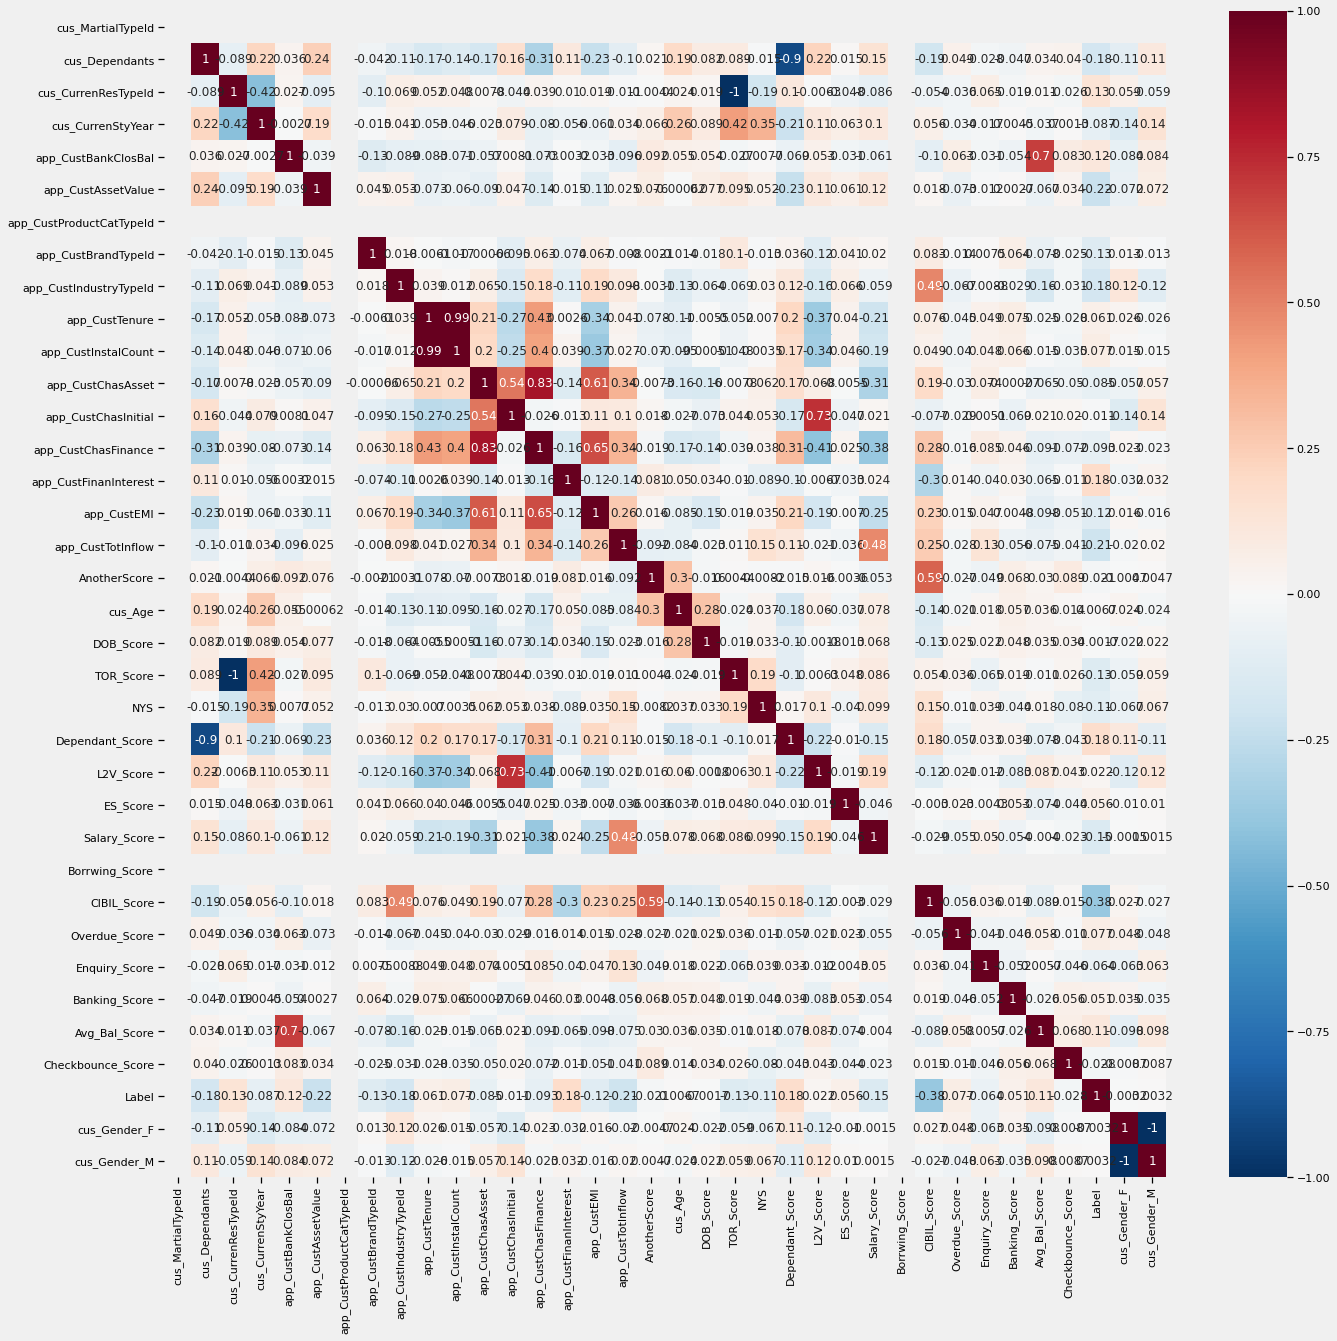

In [29]:
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.RdBu_r)
plt.show()

In [34]:
cor['Label']

cus_MartialTypeId                NaN
cus_Dependants             -0.180657
cus_CurrenResTypeId         0.133250
cus_CurrenStyYear          -0.087333
app_CustBankClosBal         0.116863
app_CustAssetValue         -0.224944
app_CustProductCatTypeId         NaN
app_CustBrandTypeId        -0.128117
app_CustIndustryTypeId     -0.181481
app_CustTenure              0.061398
app_CustInstalCount         0.076642
app_CustChasAsset          -0.084794
app_CustChasInitial        -0.011187
app_CustChasFinance        -0.093133
app_CustFinanInterest       0.183191
app_CustEMI                -0.122753
app_CustTotInflow          -0.208056
AnotherScore               -0.021341
cus_Age                     0.006693
DOB_Score                  -0.001686
TOR_Score                  -0.133250
NYS                        -0.111933
Dependant_Score             0.175200
L2V_Score                   0.022047
ES_Score                    0.056134
Salary_Score               -0.146136
Borrwing_Score                   NaN
C